# EMNIST 手寫英文字母辨識

In [1]:
# Visualization Dependencies
from IPython.display import Image, SVG
import seaborn as sns

# Filepaths, Numpy, Tensorflow
import os
import numpy as np
import tensorflow as tf

# Keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

sns.set()

### Import and Shape Data

In [2]:
# !pip install emnist

## [EMNIST 說明](https://pypi.org/project/emnist/)
## [資料集 說明](https://www.nist.gov/itl/products-and-services/emnist-dataset)

## 步驟1：資料集導入

In [3]:
# pip install emnist
# Import Dataset(s)
from emnist import list_datasets
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [4]:
# Working with 'letters'
# Import 
from emnist import extract_training_samples
images_train, labels_train = extract_training_samples('letters')
from emnist import extract_test_samples
images_test, labels_test = extract_test_samples('letters')

In [5]:
# Check shape of training and testing data
print(images_train.shape)
print(labels_train.shape)
print(images_test.shape)
print(labels_test.shape)

(124800, 28, 28)
(124800,)
(20800, 28, 28)
(20800,)


In [6]:
labels_train[1]

7

In [7]:
import pandas as pd

df = pd.DataFrame({'ascii':labels_train})
df.head()

,ascii
0,23
1,7
2,16
3,15
4,23


In [8]:
df.ascii.value_counts()

ascii
23    4800
7     4800
20    4800
3     4800
4     4800
8     4800
1     4800
12    4800
9     4800
25    4800
2     4800
5     4800
19    4800
26    4800
21    4800
18    4800
14    4800
10    4800
24    4800
22    4800
11    4800
13    4800
17    4800
15    4800
16    4800
6     4800
Name: count, dtype: int64

In [9]:
df.ascii.unique()

array([23,  7, 16, 15, 17, 13, 11, 22, 24, 10, 14, 18, 21, 26, 19,  5,  2,
       25,  9, 12,  1,  8,  4,  3, 20,  6], dtype=uint8)

In [10]:
df.ascii.nunique()

26

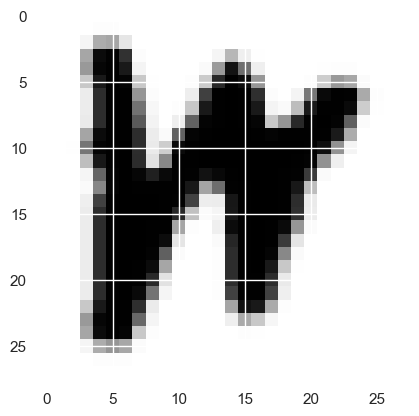

In [11]:
# Plot an image
import matplotlib.pyplot as plt
plt.imshow(images_train[0,:,:], cmap=plt.cm.Greys);

In [12]:
labels_train[0]

23

In [13]:
import pandas as pd

df = pd.read_csv('emnist-letters-mapping.txt', header=None, sep = ' ', index_col=0)
df.columns = ['ascii', 'ascii2']
df['character'] = df['ascii'].apply(lambda x: chr(x))
df['character2'] = df['ascii2'].apply(lambda x: chr(x))
df

,ascii,ascii2,character,character2
0,,,,
1,65,97,A,a
2,66,98,B,b
3,67,99,C,c
4,68,100,D,d
5,69,101,E,e
6,70,102,F,f
7,71,103,G,g
8,72,104,H,h
9,73,105,I,i


## [ASCII Table](https://www.asciitable.com/)
<img src='https://www.asciitable.com/asciifull.gif' />

In [14]:
chr(48)

'0'

In [15]:
labels_train[0], df.iloc[labels_train[0]]

(23,
 ascii          88
 ascii2        120
 character       X
 character2      x
 Name: 24, dtype: object)

In [16]:
# 調整 y class -= 1
labels_train = labels_train - 1
labels_test = labels_test - 1
labels_train[0], df.iloc[labels_train[0]]

(22,
 ascii          87
 ascii2        119
 character       W
 character2      w
 Name: 23, dtype: object)

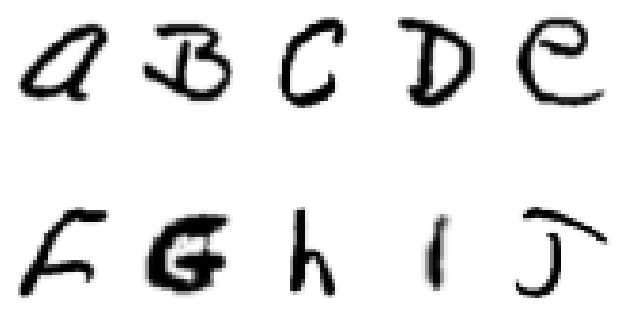

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = images_train[labels_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

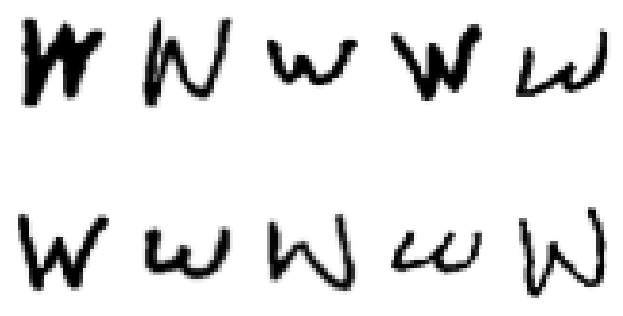

In [18]:
no=22
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = images_train[labels_train == no][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 步驟2：資料清理，此步驟無需進行

## 步驟3：進行特徵工程，將特徵縮放成(0, 1)之間

In [19]:
# 特徵縮放，使用常態化(Normalization)，公式 = (x - min) / (max - min)
# 顏色範圍：0~255，所以，公式簡化為 x / 255
# 注意，顏色0為白色，與RGB顏色不同，(0,0,0) 為黑色。
x_train_norm, x_test_norm = images_train / 255.0, images_test / 255.0
x_train_norm[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.01176471,
        0.01568627, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.07843137, 0.42745098,
        0.44705882, 0.17647059, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

## 步驟4：資料分割，此步驟無需進行，載入MNIST資料時，已經切割好了

## 步驟5：建立模型結構

In [20]:
# 建立模型
from keras.layers import Conv2D, MaxPooling2D
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3),input_shape=(28, 28, 1), activation='relu'),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),                # (A)
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),                # (B)    

  tf.keras.layers.Flatten(input_shape=(28, 28)),  # flatten 壓成一維
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(26, activation='softmax') # 0-25 共26個字母（答案）
])

In [21]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='adam',                         # adam 動態調整學習率
              loss='sparse_categorical_crossentropy',   # 分類使用交叉熵
              metrics=['accuracy'])

## 步驟6：結合訓練資料及模型，進行模型訓練

In [22]:
# 模型訓練
# callback: https://ithelp.ithome.com.tw/articles/10234641
# 自訂 callback: https://ithelp.ithome.com.tw/articles/10235293
history = model.fit(x_train_norm, labels_train, epochs=10, validation_split=0.2)
# history = model.fit(x_train_norm, y_train, epochs=5, validation_split=0.2, batch_size= 1000)

Epoch 1/10
3120/3120 [==============================] - 58s 18ms/step - loss: 0.4848 - accuracy: 0.8476 - val_loss: 0.2468 - val_accuracy: 0.9187
Epoch 2/10
3120/3120 [==============================] - 56s 18ms/step - loss: 0.2477 - accuracy: 0.9179 - val_loss: 0.2066 - val_accuracy: 0.9295
Epoch 3/10
3120/3120 [==============================] - 53s 17ms/step - loss: 0.2013 - accuracy: 0.9311 - val_loss: 0.1984 - val_accuracy: 0.9348
Epoch 4/10
3120/3120 [==============================] - 53s 17ms/step - loss: 0.1771 - accuracy: 0.9383 - val_loss: 0.1928 - val_accuracy: 0.9369
Epoch 5/10
3120/3120 [==============================] - 55s 18ms/step - loss: 0.1568 - accuracy: 0.9443 - val_loss: 0.1790 - val_accuracy: 0.9415
Epoch 6/10
3120/3120 [==============================] - 57s 18ms/step - loss: 0.1423 - accuracy: 0.9488 - val_loss: 0.1930 - val_accuracy: 0.9415
Epoch 7/10
3120/3120 [==============================] - 57s 18ms/step - loss: 0.1292 - accuracy: 0.9515 - val_loss: 0.1993 -

In [23]:
# 檢查 history 所有鍵值
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

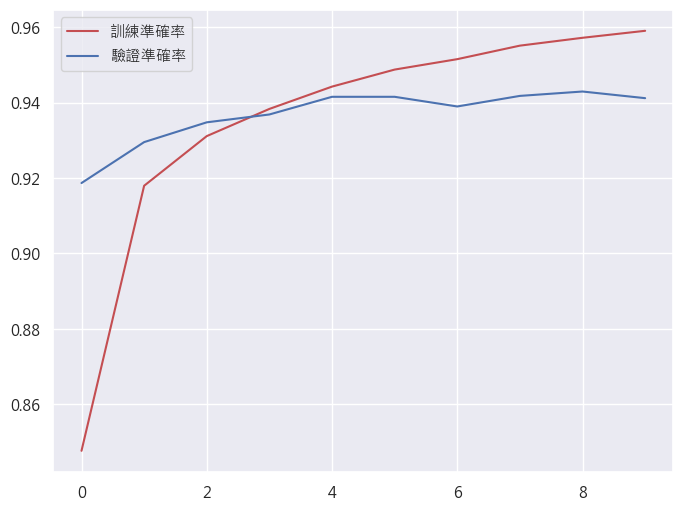

In [24]:
# 對訓練過程的準確率繪圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='訓練準確率')
plt.plot(history.history['val_accuracy'], 'b', label='驗證準確率')
plt.legend()
plt.show()

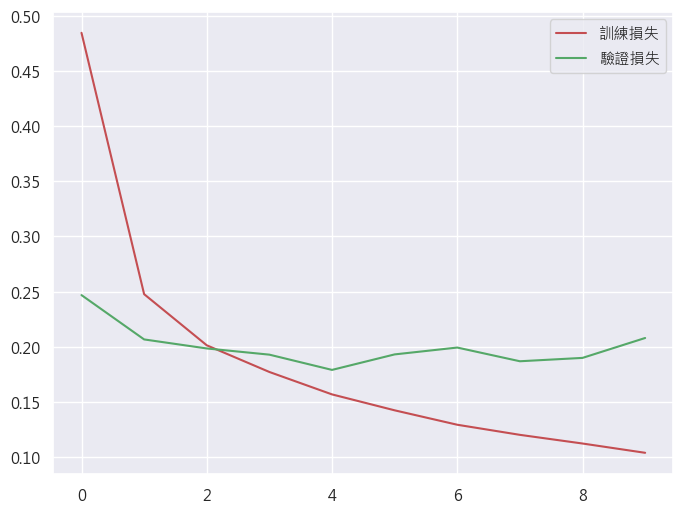

In [25]:
# 對訓練過程的損失繪圖
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], 'r', label='訓練損失')
plt.plot(history.history['val_loss'], 'g', label='驗證損失')
plt.legend()
plt.show()

## 步驟7：評分(Score Model)

In [26]:
# 評分(Score Model)
score=model.evaluate(x_test_norm, labels_test, verbose=0)

for i, x in enumerate(score):
    print(f'{model.metrics_names[i]}: {score[i]:.4f}')

loss: 0.2172
accuracy: 0.9396


In [27]:
# 實際預測 20 筆資料
# predictions = model.predict_classes(x_test_norm)
import numpy as np
predictions = np.argmax(model.predict(x_test_norm), axis=-1)

# 比對
print('actual    :', labels_test[900:920])
print('prediction:', predictions[900:920])

650/650 [==============================] - 3s 4ms/step
actual    : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
prediction: [ 1  1  1  1  1  1 11  1  1 16  1 11  1  1  1  1  1  1  1  1]


In [28]:
import numpy as np

predictions = model.predict(x_test_norm[8:9])
print(f'a~z預測機率: {np.around(predictions, 2)}')

1/1 [==============================] - 0s 65ms/step
a~z預測機率: [[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


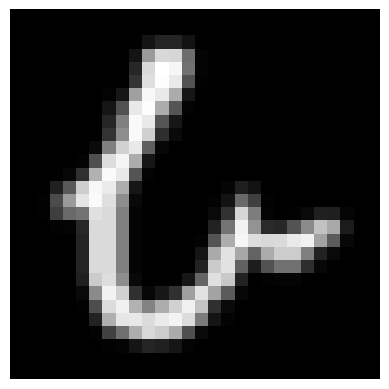

In [29]:
# 顯示第 9 筆圖像
X2 = images_test[1000,:,:]
plt.imshow(X2.reshape(28,28), cmap='gray')
plt.axis('off')
plt.show() 

## 步驟8：評估，暫不進行

## 步驟9：模型佈署

In [30]:
# 模型存檔
model.save('Emnist_model.h5')

# 模型載入
model = tf.keras.models.load_model('Emnist_model.h5')

## 步驟10：新資料預測

In [31]:
# 使用小畫家，繪製 0~9，實際測試看看
from skimage import io
from skimage.transform import resize
import numpy as np

# 讀取影像並轉為單色
uploaded_file = './test_data/d.png'
image1 = io.imread(uploaded_file, as_gray=True)
print(image1.shape)

# 縮為 (28, 28) 大小的影像
image_resized = resize(image1, (28, 28), anti_aliasing=True)    
X1 = image_resized.reshape(1,28, 28) #/ 255 skimage 已經做了縮放過

# 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
X1 = np.abs(1-X1)

# 預測
#predictions = model.predict_classes(X1)
predictions = np.argmax(model.predict(X1), axis=-1) # argmax 找出最大值所在的索引值在哪
print(predictions[0])
print(chr(predictions[0]+65))

(280, 280)
1/1 [==============================] - 0s 66ms/step
3
D


In [32]:
model.predict(X1)

1/1 [==============================] - 0s 20ms/step


array([[1.28536541e-02, 1.53285917e-03, 2.87570665e-03, 8.69443178e-01,
        1.18561438e-04, 1.21951725e-05, 3.54709453e-03, 1.22919923e-03,
        2.77900905e-03, 3.41290012e-02, 2.79005349e-06, 6.89097913e-03,
        8.19547404e-06, 6.44960615e-04, 2.18913844e-03, 5.18449779e-05,
        5.64045913e-04, 4.04472416e-07, 4.29169950e-06, 4.94268276e-02,
        1.11490656e-02, 8.79540821e-05, 2.05252672e-05, 2.58393957e-05,
        2.11104794e-04, 2.01477931e-04]], dtype=float32)

In [33]:
np.sum(model.predict(X1))

1/1 [==============================] - 0s 21ms/step


0.9999999

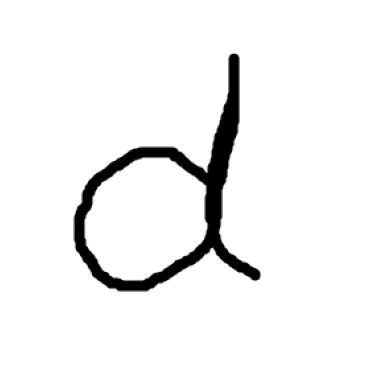

In [34]:
# 繪製點陣圖，cmap='gray':灰階
plt.imshow(image1, cmap='gray')

# 隱藏刻度
plt.axis('off') 

# 顯示圖形
plt.show() 

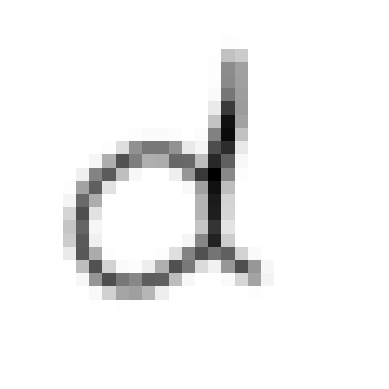

In [35]:
# 繪製點陣圖，cmap='gray':灰階
plt.imshow(image_resized, cmap='gray')

# 隱藏刻度
plt.axis('off') 

# 顯示圖形
plt.show() 

In [36]:
import os
for dirname, _, filenames in os.walk('./test_data'):
    for filename in filenames:
        uploaded_file = os.path.join(dirname, filename)
        image1 = io.imread(uploaded_file, as_gray=True)

        # 縮為 (28, 28) 大小的影像
        image_resized = resize(image1, (28, 28), anti_aliasing=True)    
        X1 = image_resized.reshape(1,28, 28) #/ 255

        # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
        X1 = np.abs(1-X1)

        # 預測
        predictions = np.argmax(model.predict(X1), axis=-1)
        print(chr(predictions[0]+65))

1/1 [==============================] - 0s 23ms/step
A
1/1 [==============================] - 0s 18ms/step
B
1/1 [==============================] - 0s 18ms/step
C
1/1 [==============================] - 0s 18ms/step
D
1/1 [==============================] - 0s 17ms/step
E
1/1 [==============================] - 0s 19ms/step
F
1/1 [==============================] - 0s 21ms/step
J
1/1 [==============================] - 0s 19ms/step
H
1/1 [==============================] - 0s 18ms/step
I
1/1 [==============================] - 0s 19ms/step
J
1/1 [==============================] - 0s 18ms/step
K
1/1 [==============================] - 0s 21ms/step
O


## 其他：顯示模型彙總資訊(summary)、繪製圖形顯示模型結構

In [37]:
# 顯示模型的彙總資訊
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0

In [38]:
import pandas as pd 
predictions = np.argmax(model.predict(x_test_norm), axis=-1)
pd.crosstab(labels_test, predictions, rownames=['實際值'], colnames=['預測值'])

650/650 [==============================] - 3s 4ms/step


預測值,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
實際值,,,,,,,,,,,,,,,,,,,,,
0,752,1,2,6,1,1,5,3,0,1,...,13,0,0,0,1,0,1,0,1,4
1,0,776,0,1,2,0,5,4,0,0,...,1,2,0,0,1,0,0,0,0,2
2,0,0,774,1,12,0,1,0,0,0,...,1,2,0,0,2,0,0,0,0,1
3,2,3,1,751,0,0,1,1,0,5,...,1,0,0,2,0,0,0,0,0,0
4,0,0,8,0,774,1,3,0,2,0,...,3,1,0,0,0,0,0,0,0,0
5,0,1,1,0,3,768,2,0,0,1,...,0,2,2,11,0,0,0,0,1,0
6,12,6,4,1,1,1,651,2,0,5,...,105,0,4,0,0,0,0,0,4,0
7,1,0,0,1,0,0,0,759,0,0,...,0,1,0,0,0,0,0,0,1,0
8,1,0,1,0,1,0,1,0,588,18,...,0,1,0,0,0,1,0,0,1,1
